In [126]:
# Import necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from glob import glob
import warnings
from tensorflow.keras.preprocessing.image import load_img

warnings.filterwarnings("ignore")

In [25]:
# Define base directory for dataset
BASE_DIR = "Skin cancer ISIC The International Skin Imaging Collaboration"

# Setup paths for training and testing data
data_dir_train = pathlib.Path(BASE_DIR) / "train"
data_dir_test = pathlib.Path(BASE_DIR) / "test"

# Validate that directories exist
if not data_dir_train.exists() or not data_dir_test.exists():
    raise FileNotFoundError(
        "Please ensure the skin lesion dataset is downloaded and placed in the correct directory structure:\n"
        f"{BASE_DIR}/\n"
        "  ├── test/\n"
        "  └── train/"
    )

In [9]:
def analyze_dataset_size(data_paths: dict) -> dict:
    """
    Analyze the size of image datasets by counting files in specified directories.
    
    Args:
        data_paths: Dictionary containing paths for different dataset splits
        
    Returns:
        Dictionary containing image counts for each split
    """
    dataset_stats = {}
    
    for split_name, path in data_paths.items():
        try:
            # Count all jpg images in subdirectories
            image_files = list(path.glob('*/*.jpg'))
            count = len(image_files)
            
            # Store results
            dataset_stats[split_name] = {
                'count': count,
                'path': path
            }
            
            print(f"{split_name.title()} set contains {count:,} images")
            
        except Exception as e:
            print(f"Error analyzing {split_name} dataset: {str(e)}")
            dataset_stats[split_name] = {'count': 0, 'path': path}
    
    return dataset_stats

# Define paths for different dataset splits
dataset_paths = {
    'training': data_dir_train,
    'testing': data_dir_test
}

# Analyze dataset sizes
dataset_statistics = analyze_dataset_size(dataset_paths)

Training set contains 2,239 images
Testing set contains 118 images


In [15]:
def analyze_dataset_distribution(root_directory):
    """
    Analyzes the distribution of images across different classes in a dataset directory.
    
    Args:
        root_directory: Path to the dataset root directory containing class subdirectories
        
    Returns:
        DataFrame containing class names and their corresponding image counts
    """
    # Initialize lists to store class info
    class_counts = []
    class_names = []
    
    # Iterate through subdirectories
    for class_dir in pathlib.Path(root_directory).iterdir():
        if class_dir.is_dir():
            # Count image files in the class directory
            image_files = [f for f in class_dir.glob('*.jpg')]
            class_counts.append(len(image_files))
            class_names.append(class_dir.name)
    
    # Create and return a pandas DataFrame with the results
    distribution_df = pd.DataFrame({
        'Class': class_names,
        'No. of Image': class_counts
    })
    
    return distribution_df.sort_values('No. of Image', ascending=False)

# Generate distribution analysis
dataset_train_stats = analyze_dataset_distribution(data_dir_train)
dataset_test_stats = analyze_dataset_distribution(data_dir_test)

dataset_train_stats, dataset_test_stats

(                        Class  No. of Image
 5  pigmented benign keratosis           462
 3                    melanoma           438
 1        basal cell carcinoma           376
 4                       nevus           357
 7     squamous cell carcinoma           181
 8             vascular lesion           139
 0           actinic keratosis           114
 2              dermatofibroma            95
 6        seborrheic keratosis            77,
                         Class  No. of Image
 0           actinic keratosis            16
 1        basal cell carcinoma            16
 2              dermatofibroma            16
 3                    melanoma            16
 4                       nevus            16
 5  pigmented benign keratosis            16
 7     squamous cell carcinoma            16
 6        seborrheic keratosis             3
 8             vascular lesion             3)

<Axes: xlabel='No. of Image', ylabel='Class'>

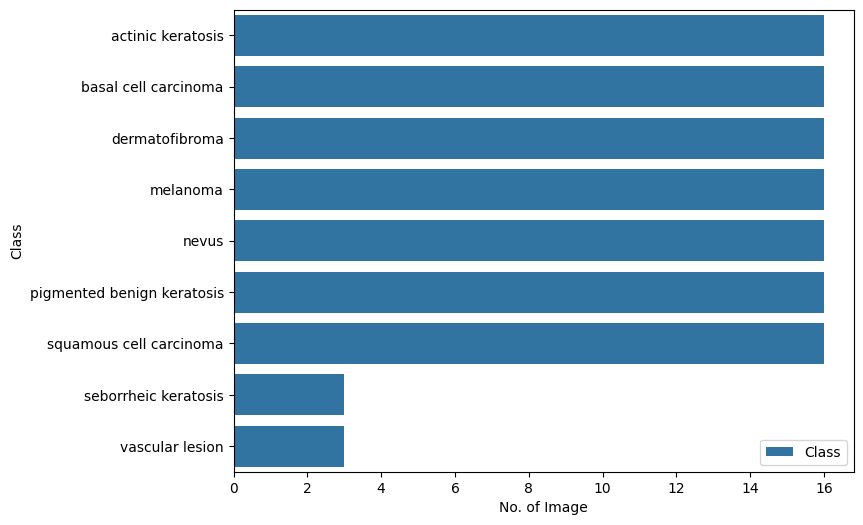

In [19]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(x="No. of Image", y="Class", data=dataset_test_stats,
            label="Class")

In [23]:
"""
Dataset Configuration:

Input Tensor Structure:
- Each batch contains 64 training samples
- Individual image dimensions: 224x224 pixels
- Channel depth: 3 (RGB color space)
- Resulting tensor shape: (64, 224, 224, 3)

Label Structure:
- One label per image in batch
- Label tensor shape: (64,)
- Each label corresponds to its respective image in the batch

These dimensions define how the data flows through the neural network,
with each batch being processed as a single unit during training.
"""
# Configure image processing parameters
TRAINING_BATCH = 32  # Number of images processed in each batch
IMAGE_DIM_X = 180    # Width dimension for input images
IMAGE_DIM_Y = 180    # Height dimension for input images

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(IMAGE_DIM_Y,IMAGE_DIM_X),
                                                               batch_size=TRAINING_BATCH,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [29]:
# Create validation subset from training data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,                      # Fixed seed for reproducibility
    validation_split=0.2,          # 20% validation split
    image_size=(IMAGE_DIM_Y, IMAGE_DIM_X),
    batch_size=TRAINING_BATCH,
    color_mode='rgb',              # Use RGB color channels
    subset='validation'            # Specify this is validation split
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [31]:
# Load and configure test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,                           # Directory containing test data
    seed=123,                                # Fixed seed for reproducibility
    image_size=(IMAGE_DIM_Y, IMAGE_DIM_X),      # Image dimensions
    batch_size=TRAINING_BATCH,                   # Batch size for processing
    color_mode='rgb'                         # Use RGB color channels
)

Found 118 files belonging to 9 classes.


In [32]:
# Extracting all the classes of skin cancer and store them in a list.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# visualization


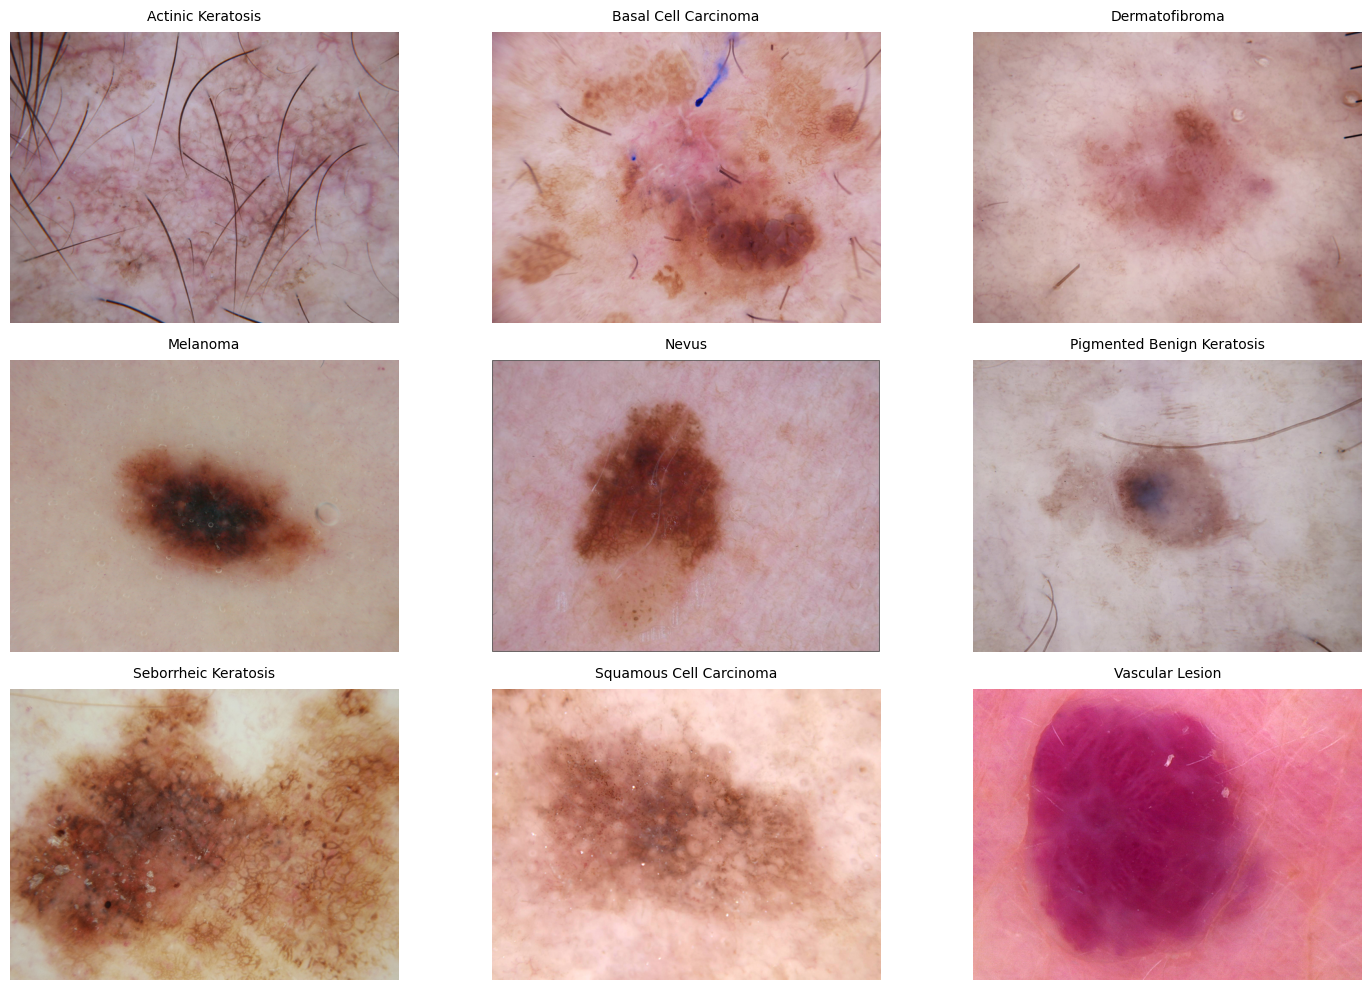

In [33]:
# Loop through class names to display one image per class
plt.figure(figsize=(15, 10))  # Reduced figure size for better display

for classnum in range(len(class_names)):
    plt.subplot(3, 3, classnum + 1)  # Changed to 3x3 grid for 9 classes
    
    # Get sample image path for current class
    image_path = str(list(data_dir_train.glob(class_names[classnum] + '/*.jpg'))[1])
    image = plt.imread(image_path)
    
    # Add title with wrapped text for better readability
    plt.title(class_names[classnum].replace('_', ' ').title(), 
              fontsize=10, 
              pad=8,
              wrap=True)
    
    plt.imshow(image)
    plt.axis('off')  # Hide axes for cleaner look

plt.tight_layout()  # Adjust spacing between subplots

In [34]:
# Define the AUTOTUNE parameter to enhance performance  
AUTO_TUNE = tf.data.experimental.AUTOTUNE  

# Apply caching and optimization to the training dataset  
training_data = train_ds.cache()
training_data = training_data.shuffle(1000)
training_data = training_data.prefetch(buffer_size=AUTO_TUNE)  

# Optimize the test dataset using caching and prefetching (no shuffling needed for test data)  
testing_data = test_ds.cache()
testing_data = testing_data.prefetch(buffer_size=AUTO_TUNE)  

# Optimize the validation dataset with caching and prefetching  
validation_data = val_ds.cache()
validation_data = validation_data.prefetch(buffer_size=AUTO_TUNE)  


In [35]:
# Function to generate plots for loss and accuracy on training and validation datasets

def visualize_cnn_performance(training_history, num_epochs):
    train_accuracy = training_history.history["accuracy"]
    validation_accuracy = training_history.history["val_accuracy"]

    train_loss = training_history.history["loss"]
    validation_loss = training_history.history["val_loss"]

    epoch_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_accuracy, label="Training Accuracy")
    plt.plot(epoch_range, validation_accuracy, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training vs Validation Accuracy")

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_loss, label="Training Loss")
    plt.plot(epoch_range, validation_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training vs Validation Loss")

    plt.show()


# Building Model and Training

In [36]:
# Defining the CNN Model
cnn_model = models.Sequential()

# Normalizing pixel values from the range 0-255 to 0-1
cnn_model.add(layers.Rescaling(scale=1.0 / 255, input_shape=(180, 180, 3)))

# First Convolutional Layer: 64 filters, 3x3 kernel, ReLU activation, and 2x2 pooling
cnn_model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer: 128 filters, 3x3 kernel, ReLU activation, and 2x2 pooling
cnn_model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer: 256 filters, 3x3 kernel, ReLU activation, and 2x2 pooling
cnn_model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(9, activation="softmax"))


In [37]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    31,719,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,092,809 (122.42 MB)

 Trainable params: 32,092,809 (122.42 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Compiling the model

cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    31,719,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,092,809 (122.42 MB)

 Trainable params: 32,092,809 (122.42 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Training the model
epochs = 20
history = cnn_model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 295ms/step - accuracy: 0.8747 - loss: 0.3383 - val_accuracy: 0.5324 - val_loss: 2.3851
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.8916 - loss: 0.3016 - val_accuracy: 0.5123 - val_loss: 2.2498
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 502ms/step - accuracy: 0.8980 - loss: 0.3131 - val_accuracy: 0.5056 - val_loss: 2.3008
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 579ms/step - accuracy: 0.9194 - loss: 0.1874 - val_accuracy: 0.5593 - val_loss: 2.2599
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 589ms/step - accuracy: 0.9182 - loss: 0.2014 - val_accuracy: 0.5145 - val_loss: 2.9125
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 577ms/step - accuracy: 0.9203 - loss: 0.1666 - val_accuracy: 0.5347 - val_loss: 2.6798
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 580ms/step - accuracy: 0.9070 - loss: 0.2005 - val_accuracy: 0.4966 - val_loss: 2.6398
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 585ms/step - accuracy: 0.9000 - loss: 0.2488 - val_accu

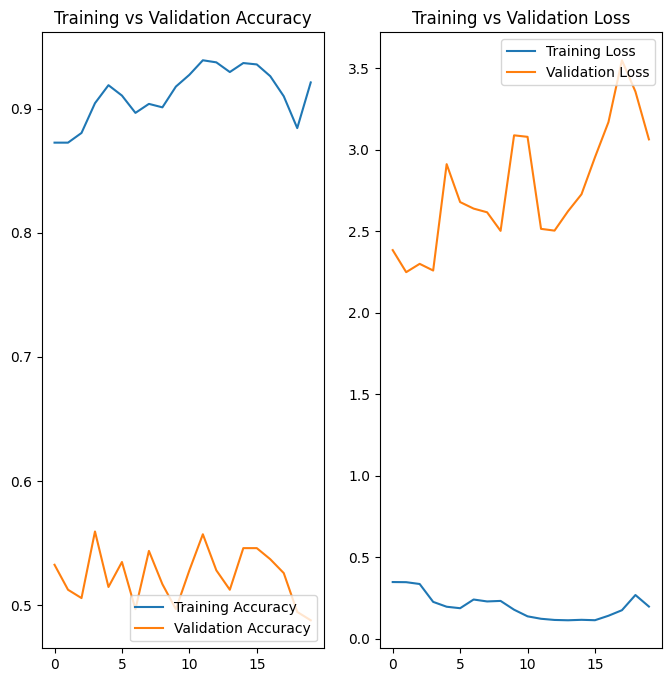

In [42]:
visualize_cnn_performance(history,epochs)

Observations:
Training Accuracy is High (~90-95%)

This suggests that your model is learning well on the training data.
Validation Accuracy is Low (~50-55%) and Fluctuating

This could indicate overfitting—your model performs well on training data but struggles with unseen validation data.
Validation Loss is Increasing

Typically, validation loss should decrease over epochs if the model is generalizing well.
Since it's rising, it suggests the model may be memorizing training data instead of learning useful patterns.
Training Loss is Low and Stable

This is expected since your model is optimizing itself well on training data.


Selecting an Effective Data Augmentation Strategy to Mitigate Overfitting
Overfitting arises when a model is exposed to a limited dataset and learns to memorize specific examples instead of identifying broader patterns. This results in high accuracy on training data but poor generalization to new, unseen samples, ultimately leading to suboptimal performance on validation or test sets.

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(IMAGE_DIM_Y,IMAGE_DIM_X,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

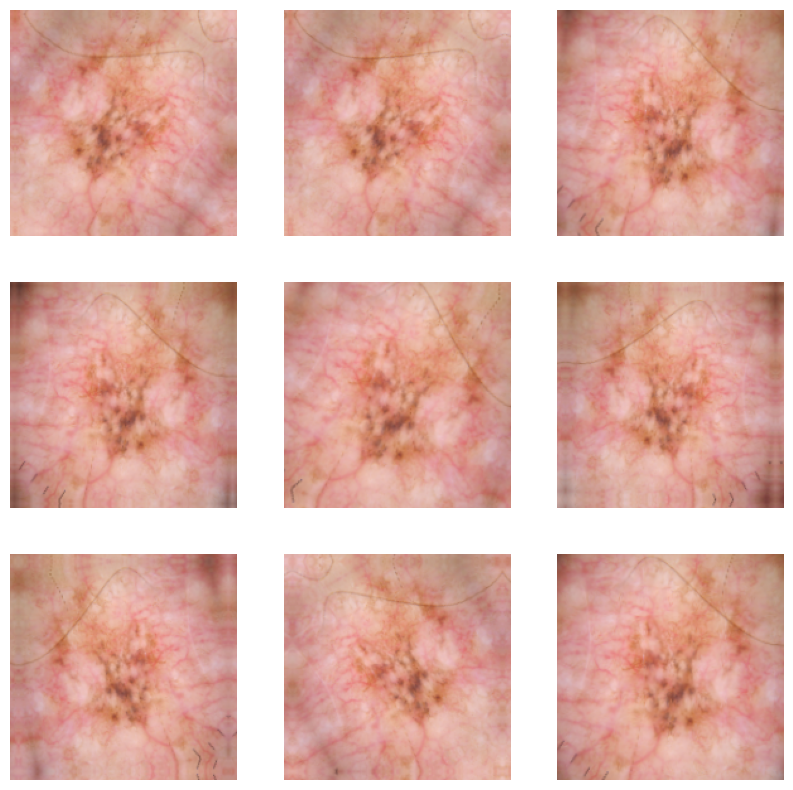

In [44]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in training_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [45]:
# Initializing a Sequential model
model = models.Sequential()

# Normalizing pixel values from 0-255 to a 0-1 range
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# Incorporating the data augmentation layer before convolutional layers
model.add(data_augmentation)

# First convolutional block: 64 filters, 3x3 kernel, ReLU activation, followed by 2x2 pooling
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second convolutional block: 128 filters, 3x3 kernel, ReLU activation, followed by 2x2 pooling
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Third convolutional block: 256 filters, 3x3 kernel, ReLU activation, followed by 2x2 pooling
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flattening the output before feeding into dense layers
model.add(Flatten())

# Fully connected layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))

# Output layer with 9 neurons and softmax activation for multi-class classification
model.add(Dense(9, activation='softmax'))


In [46]:
# Configuring the model with Adam optimizer and sparse categorical cross-entropy loss function
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
evaluation_metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=evaluation_metrics)

# Display the model architecture
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 123904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    31,719,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,092,809 (122.42 MB)

 Trainable params: 32,092,809 (122.42 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Training the model
epochs = 20
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - accuracy: 0.1723 - loss: 4.6891 - val_accuracy: 0.2058 - val_loss: 2.0645
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 324ms/step - accuracy: 0.2028 - loss: 2.0453 - val_accuracy: 0.1902 - val_loss: 2.0300
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 320ms/step - accuracy: 0.1941 - loss: 2.0422 - val_accuracy: 0.2506 - val_loss: 2.0474
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 321ms/step - accuracy: 0.2170 - loss: 2.0359 - val_accuracy: 0.2349 - val_loss: 1.9769
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 321ms/step - accuracy: 0.2417 - loss: 1.9871 - val_accuracy: 0.2662 - val_loss: 1.9946
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 321ms/step - accuracy: 0.2557 - loss: 1.9627 - val_accuracy: 0.2796 - val_loss: 1.9975
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 322ms/step - accuracy: 0.2676 - loss: 1.9360 - val_accuracy: 0.3199 - val_loss: 1.9020
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 321ms/step - accuracy: 0.3241 - loss: 1.8427 - val_accu

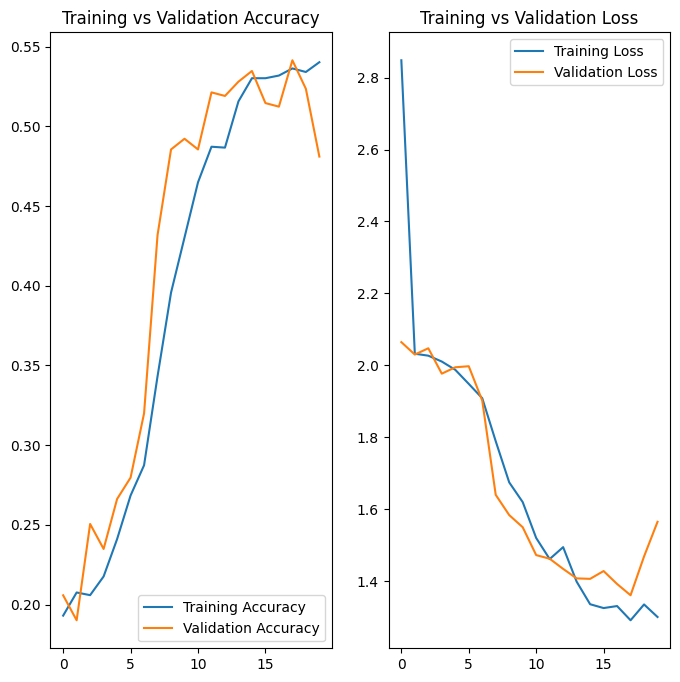

In [52]:
visualize_cnn_performance(history,epochs)

Training Accuracy vs. Validation Accuracy: Both training and validation accuracy increase steadily over epochs. Validation accuracy initially surpasses training accuracy but later fluctuates slightly, ending around 55%.

Training Loss vs. Validation Loss: Training loss decreases consistently, while validation loss initially declines but shows an upward trend toward the end. This suggests potential instability in validation performance.

Accuracy Comparison: Unlike the previous model, validation accuracy closely follows training accuracy for most epochs, indicating improved generalization.

Overfitting Observation: The final gap between training and validation accuracy is relatively small, but the late fluctuation in validation accuracy and the slight rise in validation loss indicate potential overfitting or insufficient regularization.


# Constructing the model and training it on the augmented dataset with added dropout layers:


In [55]:
# Defining the CNN model
model = models.Sequential()

# Normalizing pixel values by scaling them from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))
model.add(data_augmentation)

# First Convolutional layer: 64 filters, 3x3 kernel, ReLU activation, and 2x2 max pooling
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Applying a 25% dropout after the first convolutional block
model.add(Dropout(0.25))

# Second Convolutional layer: 128 filters, 3x3 kernel, ReLU activation, and 2x2 max pooling
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Applying a 25% dropout after the second convolutional block
model.add(Dropout(0.25))

# Third Convolutional layer: 256 filters, 3x3 kernel, ReLU activation, and 2x2 max pooling
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding another 25% dropout after the third convolutional block
model.add(Dropout(0.25))

# Flattening the output from the convolution layers
model.add(Flatten())

# Fully connected layer with 256 units and ReLU activation
model.add(Dense(256, activation='relu'))

# Output layer with 9 units for classification, using softmax activation
model.add(Dense(9, activation='softmax'))


In [56]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 123904)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    31,719,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,092,809 (122.42 MB)

 Trainable params: 32,092,809 (122.42 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Training the model
epochs = 20
history = model.fit(
  training_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 624ms/step - accuracy: 0.1696 - loss: 3.7501 - val_accuracy: 0.1655 - val_loss: 2.0310
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 618ms/step - accuracy: 0.1855 - loss: 2.0387 - val_accuracy: 0.2058 - val_loss: 2.0246
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 614ms/step - accuracy: 0.2231 - loss: 2.0169 - val_accuracy: 0.1991 - val_loss: 2.0259
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 625ms/step - accuracy: 0.2683 - loss: 1.9867 - val_accuracy: 0.2438 - val_loss: 1.9589
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 622ms/step - accuracy: 0.3010 - loss: 1.9049 - val_accuracy: 0.4295 - val_loss: 1.7867
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 622ms/step - accuracy: 0.4358 - loss: 1.6346 - val_accuracy: 0.4966 - val_loss: 1.4641
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 619ms/step - accuracy: 0.4885 - loss: 1.4512 - val_accuracy: 0.5034 - val_loss: 1.4811
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 620ms/step - accuracy: 0.4782 - loss: 1.4788 - val_accu

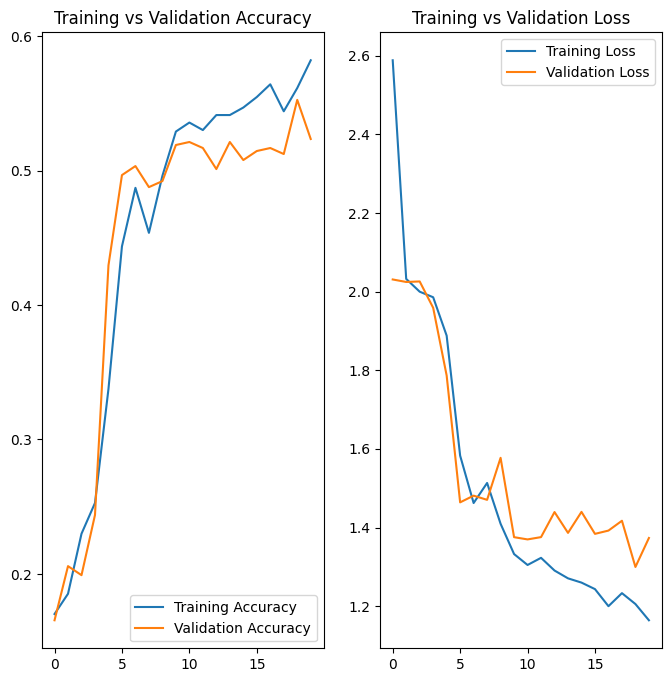

In [58]:
visualize_cnn_performance(history,epochs)

Training Accuracy vs. Validation Accuracy: Both training and validation accuracy increase significantly over epochs. Initially, they follow a similar trajectory, but training accuracy surpasses validation accuracy towards the end, peaking above 60%.

Training Loss vs. Validation Loss: Training loss decreases consistently, whereas validation loss follows a similar trend initially but fluctuates slightly in later epochs. The upward movements in validation loss suggest instability in generalization.

Accuracy Comparison: Compared to previous models, validation accuracy remains close to training accuracy, indicating improved generalization. However, the slight drop in validation accuracy at the end raises concerns.

Overfitting Observation: The increasing gap between training and validation accuracy in later epochs, combined with fluctuations in validation loss, suggests mild overfitting. Regularization techniques such as dropout, weight decay, or early stopping may help mitigate this issue.

In [59]:
for i in range(len(class_names)):
    print(
        class_names[i], " - ", len(list(data_dir_train.glob(class_names[i] + "/*.jpg")))
    )


actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


In [60]:
!pip install Augmentor

In [83]:
import Augmentor
import os

# Defining fixed directory paths for training and augmented data storage
train_data_path = r"C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
aug_path = r"C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data"

# Ensure class names are valid and directory exists
for i in class_names:
    class_train_path = os.path.join(train_data_path, i)  # Use os.path.join for correct path formation
    class_aug_path = os.path.join(aug_path, i)

    if not os.path.exists(class_train_path):  # Check if directory exists
        print(f"Warning: The directory {class_train_path} does not exist.")
        continue  # Skip this class if directory does not exist

    p = Augmentor.Pipeline(class_train_path, output_directory=class_aug_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Adding 500 samples per class to balance the dataset


Initialised with 114 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28E503F8A00>: 100%|██████████| 500/500 [00:00<00:00, 802.75 Samples/s]                   


Initialised with 376 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28E2AB7B520>: 100%|██████████| 500/500 [00:00<00:00, 806.45 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28E2B997640>: 100%|██████████| 500/500 [00:00<00:00, 769.23 Samples/s]                   


Initialised with 438 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x28E50382740>: 100%|██████████| 500/500 [00:02<00:00, 214.01 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\nevus.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28E2AC64EE0>: 100%|██████████| 500/500 [00:02<00:00, 239.64 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28E2C7FB9D0>: 100%|██████████| 500/500 [00:00<00:00, 774.46 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x28E2A99DCC0>: 100%|██████████| 500/500 [00:01<00:00, 498.25 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\squamous cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28E55B82740>: 100%|██████████| 500/500 [00:00<00:00, 776.40 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to C:\Users\hemal\OneDrive\Desktop\Upgard Studies\deep learning\case study\augmented_data\vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28E2A9FCEB0>: 100%|██████████| 500/500 [00:00<00:00, 789.54 Samples/s]                   


In [84]:
data_dir_train = pathlib.Path(aug_path)
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


In [85]:

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [86]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])
df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

In [ ]:
# Configure image processing parameters
TRAINING_BATCH = 32  # Number of images processed in each batch
IMAGE_DIM_X = 180    # Width dimension for input images
IMAGE_DIM_Y = 180    # Height dimension for input images

In [87]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(IMAGE_DIM_Y, IMAGE_DIM_X),
  batch_size=TRAINING_BATCH)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [88]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(IMAGE_DIM_Y, IMAGE_DIM_X),
  batch_size=TRAINING_BATCH)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


Constructing and training the model using the corrected class imbalance data:

* Designing a CNN architecture capable of accurately classifying the 9 distinct categories within the dataset, with image rescaling applied to normalize pixel values to the range (0,1).
* Selecting an optimal optimizer and loss function to effectively train the model.
* Training the model for approximately 30 epochs.
* Visualizing the training results to assess the presence of any overfitting or underfitting through plotted graphs.


In [89]:
# Building the CNN model
final_model  = models.Sequential()

# Rescaling pixel values to the range [0, 1] by dividing by 255
final_model .add(layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))
final_model .add(data_augmentation)

# First Convolutional layer with 64 filters, 3x3 kernel, ReLU activation, followed by 2x2 max pooling
final_model .add(Conv2D(64, (3, 3), activation='relu'))
final_model .add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional layer with 128 filters, 3x3 kernel, ReLU activation, followed by 2x2 max pooling
final_model .add(Conv2D(128, (3, 3), activation='relu'))
final_model .add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional layer with 256 filters, 3x3 kernel, ReLU activation, followed by 2x2 max pooling
final_model .add(Conv2D(256, (3, 3), activation='relu'))
final_model .add(MaxPooling2D(pool_size=(2, 2)))

# Applying 25% dropout after the convolution layers to prevent overfitting
final_model .add(Dropout(0.25))

# Flattening the output to feed into the fully connected layers
final_model .add(Flatten())

# Dense layer with 256 units and ReLU activation
final_model .add(Dense(256, activation='relu'))

# Output layer with 9 units and softmax activation for classification
final_model .add(Dense(9, activation='softmax'))


In [90]:
# Compiling the model
final_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
final_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 178, 178, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 89, 89, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 87, 87, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 43, 43, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 41, 41, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 102400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    26,214,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,587,785 (101.42 MB)

 Trainable params: 26,587,785 (101.42 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Training the model
epochs = 30
history = final_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 517ms/step - accuracy: 0.1736 - loss: 2.2201 - val_accuracy: 0.2707 - val_loss: 2.0225
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 518ms/step - accuracy: 0.3904 - loss: 1.5699 - val_accuracy: 0.4922 - val_loss: 1.4727
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 524ms/step - accuracy: 0.4520 - loss: 1.4173 - val_accuracy: 0.4385 - val_loss: 1.5669
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 521ms/step - accuracy: 0.4831 - loss: 1.3478 - val_accuracy: 0.4787 - val_loss: 1.3508
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 522ms/step - accuracy: 0.5180 - loss: 1.2790 - val_accuracy: 0.5078 - val_loss: 1.2587
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 526ms/step - accuracy: 0.5500 - loss: 1.2127 - val_accuracy: 0.5436 - val_loss: 1.3509
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 533ms/step - accuracy: 0.5363 - loss: 1.1868 - val_accuracy: 0.5324 - val_loss: 1.3390
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 526ms/step - accuracy: 0.5507 - loss: 1

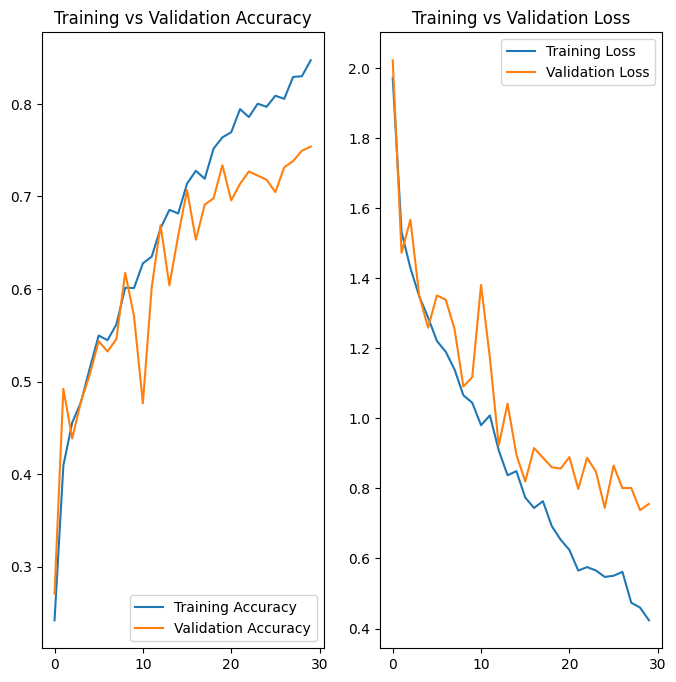

In [92]:
visualize_cnn_performance(history,epochs)

Training Accuracy vs. Validation Accuracy: Training accuracy steadily increases and surpasses 85%, while validation accuracy also improves, reaching around 75%. However, validation accuracy shows fluctuations, suggesting some instability.

Training Loss vs. Validation Loss: Both training and validation loss decrease over time. However, validation loss exhibits some fluctuations before stabilizing, indicating potential variations in validation performance.

Accuracy Comparison: The model shows a significant improvement in both training and validation accuracy compared to earlier models. The validation accuracy is closer to training accuracy, indicating better generalization.

Overfitting Observation: Although the accuracy gap has narrowed, the fluctuations in validation loss suggest possible mild overfitting. Regularization techniques such as dropout, data augmentation, or early stopping might help further stabilize validation performance.

## Prediction

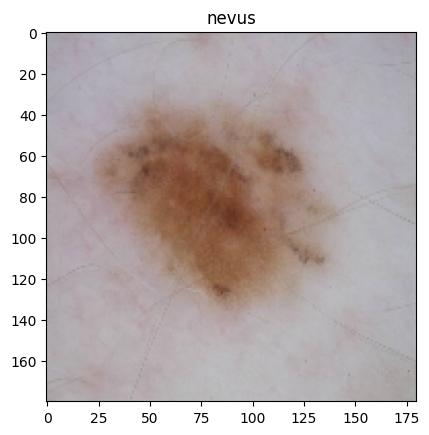

In [127]:
chosen_class = class_names[-5]
Test_image_path = os.path.join(data_dir_test, chosen_class, '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.title(chosen_class)
plt.grid(False)



In [125]:

img = np.expand_dims(Test_image,axis=0)
pred = final_model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ chosen_class +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Actual Class nevus
Predictive Class nevus
